# Distance along CC path
setting "0" as centre of the the Northern CCS, negative upstream, and positive downstream

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from cartopy import crs, feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import geopandas as gpd
from pyproj import Geod
from shapely.ops import unary_union
from cartopy.io.shapereader import natural_earth, Reader
from shapely.geometry import Point, MultiPoint, GeometryCollection, LineString
from shapely.ops import unary_union
from cartopy.feature import NaturalEarthFeature
from shapely.geometry import (
    Point, MultiPoint, LineString, MultiLineString, GeometryCollection
)

import warnings
warnings.filterwarnings("ignore")

# Functions

In [2]:
def isobath_lon(lat):
    """
    Return the easternmost longitude of the 2 000 m isobath at this latitude.
    Handles Point, MultiPoint, LineString, MultiLineString, and GeometryCollection.
    """
    # build a horizontal scan line across your plotting lon‐range
    scan = LineString([ (xlim[0], lat), (xlim[1], lat) ])
    result = iso2k.intersection(scan)

    # collect candidate points
    pts = []
    if isinstance(result, Point):
        pts = [result]
    elif isinstance(result, MultiPoint):
        pts = list(result.geoms)
    elif isinstance(result, LineString):
        # take both end‐points of the overlap segment
        pts = [Point(c) for c in result.coords]
    elif isinstance(result, MultiLineString):
        # flatten all the segment end‐points
        for seg in result.geoms:
            pts.extend(Point(c) for c in seg.coords)
    elif isinstance(result, GeometryCollection):
        for geom in result.geoms:
            if isinstance(geom, Point):
                pts.append(geom)
            elif isinstance(geom, LineString):
                pts.extend(Point(c) for c in geom.coords)
            elif isinstance(geom, MultiLineString):
                for seg in geom.geoms:
                    pts.extend(Point(c) for c in seg.coords)
    else:
        raise RuntimeError(f"Unexpected intersection type: {type(result)}")

    # filter to the Pacific shelf‐break window and pick the easternmost
    pts = [p for p in pts if -140 < p.x < -115]
    if not pts:
        raise ValueError(f"No 2 000 m isobath found at lat={lat}")
    return max(p.x for p in pts)





def along_track_distance(lon_pt, lat_pt):
    """
    Compute the signed distance (in km) along your custom two-segment line
    from an arbitrary point (lon_pt, lat_pt).

    Positive distances run southward from the pivot; negative run westward.

    Parameters
    ----------
    lon_pt, lat_pt : float
        Longitude and latitude of the query point.

    Defined earlier in the code
    ---------------------------
    lons1_off, lats1_off : array-like
        Longitude and latitude of the southward (positive) leg.
    d1 : array-like
        Cumulative positive distances (m) along the southward leg.
    lons2, lats2 : array-like
        Longitude and latitude of the westward (negative) leg.
    d2 : array-like
        Cumulative negative distances (m) along the westward leg.
    geod : pyproj.Geod
        Geodetic object used to calculate great-circle distances.

    Returns
    -------
    float
        Signed along-track distance in kilometers.
    """
    # Compute distance from query point to each vertex on the southward leg
    _, _, dist1 = geod.inv(
        lons1_off, lats1_off,
        np.full_like(lons1_off, lon_pt),
        np.full_like(lats1_off, lat_pt)
    )
    idx1 = np.argmin(dist1)

    # Compute distance from query point to each vertex on the westward leg
    _, _, dist2 = geod.inv(
        lons2, lats2,
        np.full_like(lons2, lon_pt),
        np.full_like(lats2, lat_pt)
    )
    idx2 = np.argmin(dist2)

    # Return signed distance from the closest segment (converted to km)
    if dist1[idx1] < dist2[idx2]:
        return d1[idx1] / 1000.0
    else:
        return d2[idx2] / 1000.0

# Path Line

Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #491 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included b

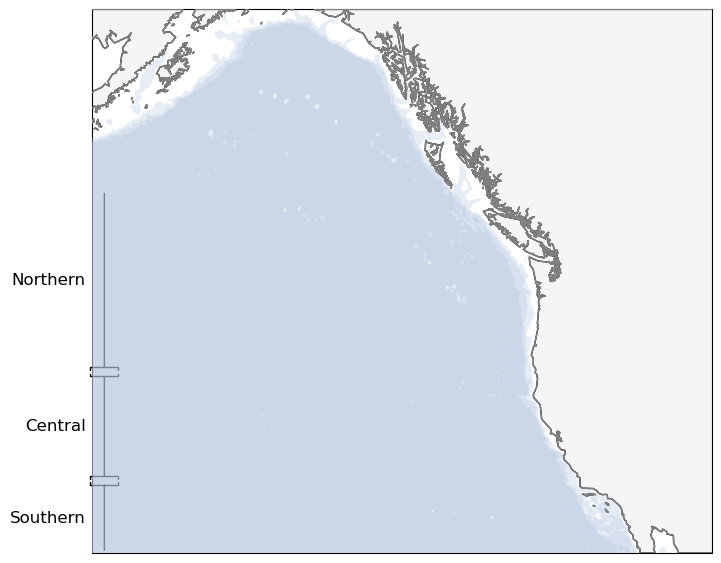

In [3]:
ylim = [30,60]
xlim = [-160,-110]
fig, ax = plt.subplots(1,1, figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

# Make plot area
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('low', facecolor='whitesmoke', zorder=2))
ax.add_feature(feature.GSHHSFeature('low', edgecolor='grey', zorder=4))

# and bathymetry..?
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_K_200', scale='10m', category='physical',facecolor='lightsteelblue',alpha=0.3, zorder=4))
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical',facecolor='lightsteelblue',alpha=0.3,zorder=4))
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_I_2000', scale='10m', category='physical',facecolor='lightsteelblue',alpha=0.3,zorder=4))




## CCS SUBREGIONS
# define the section lat‐bounds (°N)
sections = {
    'Southern': (30, 33.9),
    'Central':  (34.1, 39.9),
    'Northern': (40.1, 50),
}

style = [']-',']-[','-[']
i=0
for name, (lat0, lat1) in sections.items():
    # convert data‐space lat to axes‐fraction [0,1]
    f0 = (lat0 - ylim[0]) / (ylim[1] - ylim[0])
    f1 = (lat1 - ylim[0]) / (ylim[1] - ylim[0])

    # draw the bracket line
    ax.annotate(
        '', 
        xy=(0.02, f0), 
        xytext=(0.02, f1), 
        xycoords='axes fraction',
        arrowprops=dict(
            arrowstyle=style[i],    # bracket style
            lw=1,               # line width
            color='k',
        )
    )
    i+=1

    # place the text just to the left of the bracket
    ax.text(
        -0.01, 
        0.5*(f0+f1), 
        name,
        transform=ax.transAxes,
        va='center',
        ha='right',
        fontsize=12
    )



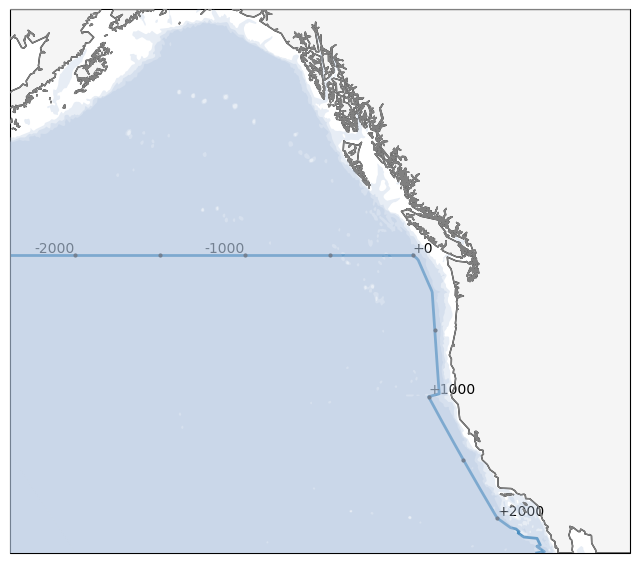

In [4]:
ylim = [30,60]
xlim = [-160,-110]
fig, ax = plt.subplots(1,1, figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

# Make plot area
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('low', facecolor='whitesmoke', zorder=2))
ax.add_feature(feature.GSHHSFeature('low', edgecolor='grey', zorder=4))

# and bathymetry..?
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_K_200', scale='10m', category='physical',facecolor='lightsteelblue',alpha=0.3, zorder=4))
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical',facecolor='lightsteelblue',alpha=0.3,zorder=4))
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_I_2000', scale='10m', category='physical',facecolor='lightsteelblue',alpha=0.3,zorder=4))

# … coastline & bathymetry here …

# — PARAMETERS —
pivot_lat = 48.5             # switch-over latitude
offset_m = 50e3             # 100 km offshore
tick_km = 2000               # label every 2000 km
leg_samps = 200              # how many points along each leg

# geodesic helper
geod = Geod(ellps='WGS84')

# grab the 2 000 m isobath as a Shapely geometry
iso2k_feature = NaturalEarthFeature(
    category='physical',
    name='bathymetry_I_2000',
    scale='10m',
)
iso2k = unary_union(list(iso2k_feature.geometries()))
iso2k = iso2k.simplify(tolerance=0.8, preserve_topology=True)

# — 1) build the coast-following leg, sample latitudes from pivot down to 30°N —
lats1 = np.linspace(pivot_lat, ylim[0], leg_samps)
lons1_coast = np.array([isobath_lon(lat) for lat in lats1])

# offset each point 200 km offshore (az=270°)
azs1 = np.full_like(lons1_coast, 270.0)
lons1_off, lats1_off, _ = geod.fwd(lons1_coast, lats1, azs1, np.full(leg_samps, offset_m))

# compute cumulative distances along leg1 (positive)
# first compute each segment length, then cumsum
_, _, segd1 = geod.inv(lons1_off[:-1], lats1_off[:-1],
                       lons1_off[1:],  lats1_off[1:])
d1 = np.concatenate([[0], np.cumsum(segd1)])

# — 2) build the westward leg along pivot_lat, starting at the pivot point offshore —
# find the pivot offshore coords explicitly
pivot_lon_coast = isobath_lon(pivot_lat)
pivot_lon_off, pivot_lat_off, _ = geod.fwd(
    pivot_lon_coast, pivot_lat,
    270, offset_m
)

lons2 = np.linspace(pivot_lon_off, xlim[0], leg_samps)
lats2 = np.full_like(lons2, pivot_lat_off)

# distances from pivot (negative going west)
_, _, d2raw = geod.inv(
    np.full(leg_samps, pivot_lon_off),
    np.full(leg_samps, pivot_lat_off),
    lons2, lats2
)
d2 = -d2raw

# — 3) plot the two legs —
ax.plot(lons1_off, lats1_off,
        '-', transform=crs.PlateCarree(), color='tab:blue', lw=2)
ax.plot(lons2, lats2,
        '-', transform=crs.PlateCarree(), color='tab:blue', lw=2)

# — 4) place tick-marks at every ±1000 km —
ticks = [-2000e3,-1500e3,-1000e3,-500e3,0,500e3,1000e3,1500e3,2000e3]

for t in ticks:
    if t < 0:
        # find westward leg
        idx = np.argmin(np.abs(d2 - t))
        lon_t, lat_t = lons2[idx], lats2[idx]
        ha = 'right'
    else:
        # find southward leg
        idx = np.argmin(np.abs(d1 - t))
        lon_t, lat_t = lons1_off[idx], lats1_off[idx]
        ha = 'left'

    # draw the little tick
    ax.plot([lon_t], [lat_t],
            marker='.', markersize=4,
            transform=crs.PlateCarree(), color='k')

for t in ticks[::2]:
    if t < 0:
        # find westward leg
        idx = np.argmin(np.abs(d2 - t))
        lon_t, lat_t = lons2[idx], lats2[idx]
        ha = 'right'
    else:
        # find southward leg
        idx = np.argmin(np.abs(d1 - t))
        lon_t, lat_t = lons1_off[idx], lats1_off[idx]
        ha = 'left'
    #  label in km
    ax.text(lon_t, lat_t, f"{int(t/1e3):+d}",
            transform=crs.PlateCarree(),
            va='bottom', ha=ha, fontsize=10)

In [5]:
along_track_distance(-144.9, 50.1) # ocean station papa

np.float64(-1275.8829412746081)